# Otimização do modelo de classificação

No arquivo anterior foi selecionado o modelo XGBoost para realizar as classificações das falhas dos equipamentos. Neste documento será feita a otimização dos parâmetros do modelo em busca de obter melhores classificações.

## Importação das bibliotecas e pacotes necessários.

In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef

/home/duartejr/anaconda3/envs/indicium/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Leitura dos dados

In [2]:
dados = pd.read_csv('desafio_manutencao_preditiva_treino.csv')

## Preparação dos dados

Os dados são preparados de acordo com o mostrado no arquivo anterior.

In [3]:
dados.drop(['udi', 'product_id'], axis=1, inplace=True)
dados = dados.drop(columns='air_temperature_k')
X = dados.drop(columns='failure_type') # Variáveis independentes
y = dados[['failure_type']] # Variável dependente
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=.3, stratify=y, random_state=101)
X_treino = pd.get_dummies(X_treino)
X_teste = pd.get_dummies(X_teste)
encoder = LabelEncoder()
encoder.fit(y_teste)
y_teste = encoder.transform(y_teste)
y_treino = encoder.transform(y_treino)

/home/duartejr/anaconda3/envs/indicium/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/duartejr/anaconda3/envs/indicium/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


## Registros das performaces do modelo

In [4]:
performaces = pd.DataFrame(columns=['Acurácia', 'Recall', 'Precisão', 'F1-Score',
                                     'MCC score', 'Tempo de treinamento', 
                                     'Tempo de predição', 'Tempo total'])

def avaliacao_modelo(y_teste, y_predito, modelo):
    acuracia = accuracy_score(y_teste, y_predito)
    precisao = precision_score(y_teste, y_predito, average='weighted')
    recall = recall_score(y_teste, y_predito, average='weighted')
    f1s = f1_score(y_teste, y_predito, average='weighted')
    MCC = matthews_corrcoef(y_teste, y_predito)

    print("Acurácia: "+ "{:.2%}".format(acuracia))
    print("Recall: "+ "{:.2%}".format(recall))
    print("Precisão: "+ "{:.2%}".format(precisao))
    print("F1-Score: "+ "{:.2%}".format(f1s))
    print("MCC: "+ "{:.2%}".format(MCC))
    print("Tempo de treino: "+ "{:.2f}".format(fim_treino - inicio)+" s")
    print("Tempo para previsão: "+"{:.2f}".format(fim_previsao - fim_treino)+" s")
    print("Total: "+"{:.2f}".format(fim_treino - inicio)+" s")
    performaces.loc[modelo] = [acuracia, recall, precisao, f1s,
                               MCC, fim_treino - inicio, 
                               fim_previsao - fim_treino,
                               fim_previsao - inicio]

## Versão original

In [5]:
%%time
inicio = time.time()
model_xgb = XGBClassifier()
model_xgb.fit(X_treino, y_treino)
fim_treino = time.time()
y_predito = model_xgb.predict(X_teste)
fim_previsao = time.time()

/home/duartejr/anaconda3/envs/indicium/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/duartejr/anaconda3/envs/indicium/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:36:15] WARNING: /croot/xgboost-split_1675119646044/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 19.2 s, sys: 532 ms, total: 19.7 s
Wall time: 2.96 s


In [6]:
avaliacao_modelo(y_teste, y_predito, 'XGBoost Classifier')

Acurácia: 97.65%
Recall: 97.65%
Precisão: 96.91%
F1-Score: 97.04%
MCC: 58.53%
Tempo de treino: 2.93 s
Tempo para previsão: 0.03 s
Total: 2.93 s


/home/duartejr/anaconda3/envs/indicium/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Seleção de variáveis

Na célula a seguir é calculada a importância de cada uma das variáveis para a classificação realizada pelo XGBoost. Vê-se que as principais variáveis são: `torque_nm`, `type_L` e `rotational_speed_rpm`.

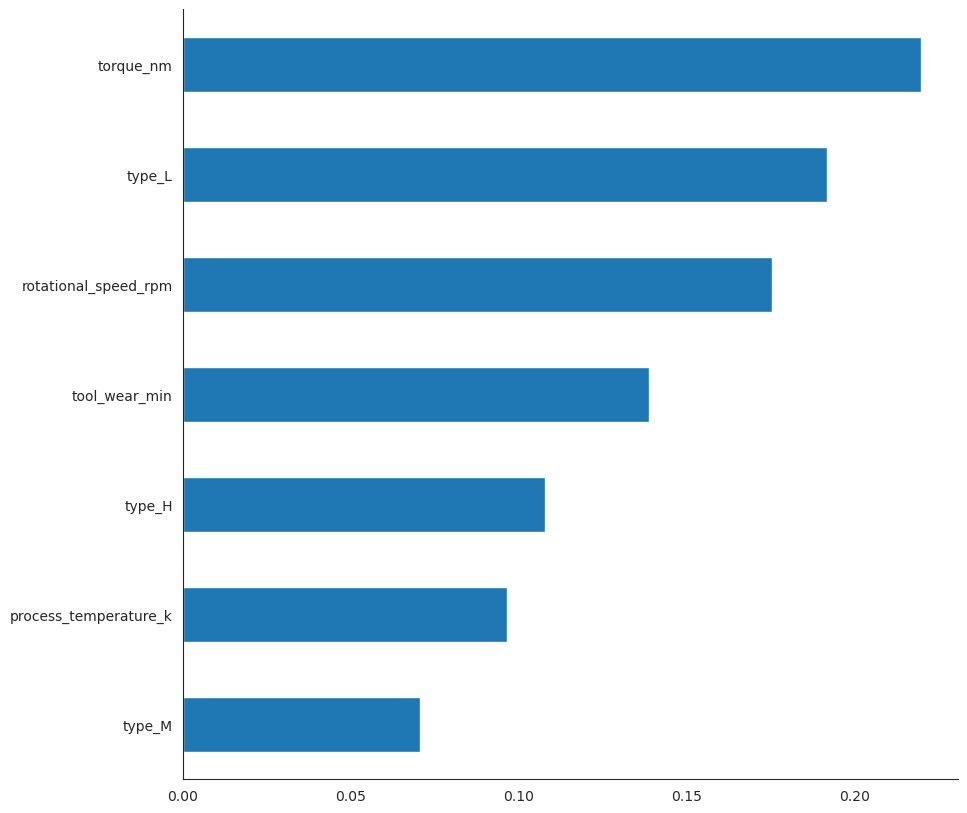

In [7]:
plt.rcParams['figure.figsize']=10,10
sns.set_style("white")
feat_importances = pd.Series(model_xgb.feature_importances_, index=X_treino.columns)
feat_importances = feat_importances.groupby(level=0).mean()
feat_importances.nlargest(20).plot(kind='barh').invert_yaxis()
sns.despine()
plt.show()

A seguir é testada uma versão do modelo removendo-se a variável menos importante: `type_M`.


In [8]:
%%time
inicio = time.time()
model_xgb = XGBClassifier()
model_xgb.fit(X_treino.drop(columns=['type_M']), y_treino)
fim_treino = time.time()
y_predito = model_xgb.predict(X_teste.drop(columns=['type_M']))
fim_previsao = time.time()

/home/duartejr/anaconda3/envs/indicium/lib/python3.10/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/duartejr/anaconda3/envs/indicium/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:36:28] WARNING: /croot/xgboost-split_1675119646044/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 7.86 s, sys: 92.3 ms, total: 7.96 s
Wall time: 1.02 s


/home/duartejr/anaconda3/envs/indicium/lib/python3.10/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [9]:
avaliacao_modelo(y_teste, y_predito, 'XGBoost Classifier -1var')

Acurácia: 97.50%
Recall: 97.50%
Precisão: 96.22%
F1-Score: 96.80%
MCC: 55.36%
Tempo de treino: 1.01 s
Tempo para previsão: 0.01 s
Total: 1.01 s


/home/duartejr/anaconda3/envs/indicium/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Otimização de parâmetros

Para otimizar os parâmetros do modelo será utilizado o `HalvingGridSearchCV` do Scikit-Learn. Este método realiza uma busca, dentro do espaço amostral de parâmetros informado, buscando o conjunto que maximiza o desempenho do modelo. Ele realiza validação cruzada e, diferentemente de outros métodos que fazem uma busca aleatória dos parâmetros, ele conta com um método de busca que otimizado. Este método de busca varre o espaço amostral pecorrendo o caminho de melhor desempenho do modelo.

Primeiramente serão testadas modificações no parâmetros: `max_depth` e `max_leaves`.

In [10]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

In [116]:
model_xgb = XGBClassifier()
param_grid = {"max_depth": [1, 2, 3, 4, 5, 10, None],
              "max_leaves": [1, 5, 10, 15, 20]}           

search = HalvingGridSearchCV(model_xgb, param_grid, resource='n_estimators',
                             max_resources=200, random_state=101,
                             scoring='f1_weighted').fit(X_treino, y_treino)
search.best_params_

{'max_depth': 10, 'max_leaves': 15, 'n_estimators': 189}

A seguir é executado o retreino do modelo com a resposta da otimização anterior.

In [127]:
%%time
inicio = time.time()
model_xgb = XGBClassifier(max_depth=10, max_leaves=15, n_estimators=189)

model_xgb.fit(X_treino, y_treino)
fim_treino = time.time()
y_predito = model_xgb.predict(X_teste)
fim_previsao = time.time()
avaliacao_modelo(y_teste, y_predito, 'XGBoost Classifier Healving 01')

Acurácia: 97.45%
Recall: 97.45%
Precisão: 96.17%
F1-Score: 96.76%
MCC: 54.35%
Tempo de treino: 0.88 s
Tempo para previsão: 0.01 s
Total: 0.88 s
CPU times: total: 5.98 s
Wall time: 899 ms


c:\Users\duart\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Em sequência serão testadas modificações nos parâmetros: `gamma`, `reg_alpha` e `reg_lamda`.

In [ ]:
model_xgb = XGBClassifier()
param_grid = {"gamma": np.arange(0, 1.1, 0.1),
              "reg_alpha": np.arange(-1, 1.1, 0.1),
              'reg_lambda': np.arange(-1, 1.1, 0.1)}           
search = HalvingGridSearchCV(model_xgb, param_grid, resource='n_estimators',
                             max_resources=200, random_state=101,
                             scoring='f1_weighted').fit(X_treino, y_treino)
search.best_params_

In [120]:
search.best_params_

{'gamma': 0.4,
 'reg_alpha': 0.09999999999999964,
 'reg_lambda': 0.49999999999999956,
 'n_estimators': 81}

Executa-se o retreino do modelo com a resposta da etapa anterior.

In [128]:
%%time
inicio = time.time()
model_xgb = XGBClassifier(gamma=0.4, reg_alpha=0.099, reg_lambda=0.499, n_estimators=81)

model_xgb.fit(X_treino, y_treino)
fim_treino = time.time()
y_predito = model_xgb.predict(X_teste)
fim_previsao = time.time()
avaliacao_modelo(y_teste, y_predito, 'XGBoost Classifier Healving 02')

Acurácia: 97.30%
Recall: 97.30%
Precisão: 95.99%
F1-Score: 96.59%
MCC: 51.08%
Tempo de treino: 0.47 s
Tempo para previsão: 0.00 s
Total: 0.47 s
CPU times: total: 2.88 s
Wall time: 485 ms


c:\Users\duart\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Finalmente têm o resultado de todas as tentativas de otimização do modelo.

In [129]:
performaces.fillna(.90,inplace=True)
performaces.style.background_gradient(cmap='coolwarm').format({'Acurácia': '{:.2%}',
                                                               'Precisão': '{:.2%}',
                                                               'Recall': '{:.2%}',
                                                               'F1-Score': '{:.2%}',
                                                               'MCC score': '{:.2%}',
                                                               'Tempo de treinamento':'{:.1f}',
                                                               'Tempo de predição':'{:.1f}',
                                                               'Tempo total':'{:.1f}',
                                                               })

,Acurácia,Recall,Precisão,F1-Score,MCC score,Tempo de treinamento,Tempo de predição,Tempo total
XGBoost Classifier,97.65%,97.65%,96.91%,97.04%,58.53%,0.5,0.0,0.6
XGBoost Classifier -1var,97.50%,97.50%,96.22%,96.80%,55.36%,0.5,0.0,0.5
XGBoost Classifier Healving 01,97.45%,97.45%,96.17%,96.76%,54.35%,0.9,0.0,0.9
XGBoost Classifier Healving 02,97.30%,97.30%,95.99%,96.59%,51.08%,0.5,0.0,0.5


## Conclusões 

Os resultados mostram que a melhor configuração para o modelo é a padrão. Ainda poderiam ser testadas outras configurações e métodos de otimização mas devido a limitações de tempo e poder computacionais não puderão ser testadas neste trabalho. Portanto a próxima etapa seguirá com a implementação do modelo selecionado.